In [1]:
# importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [2]:
#Creating Dataframes
train = pd.read_csv(r"C:\Users\USER\Downloads\Corona_NLP_train.csv", encoding='ISO-8859-1')
test = pd.read_csv(r"C:\Users\USER\Downloads\Corona_NLP_test.csv", encoding='ISO-8859-1')

### Exploratory Data Analysis

In [3]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
UserName         41157 non-null int64
ScreenName       41157 non-null int64
Location         32567 non-null object
TweetAt          41157 non-null object
OriginalTweet    41157 non-null object
Sentiment        41157 non-null object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [5]:
#Check for missing values in train dataset
train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [6]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [7]:
test.tail()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative
3797,3798,48750,"Arlington, Virginia",16-03-2020,I and @ForestandPaper members are committed to...,Extremely Positive


In [8]:
test.isnull().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [9]:
# Check top 10 locations with the highest number of Covid19 tweets
train['Location'].value_counts()[:10]

London             540
United States      528
London, England    520
New York, NY       395
Washington, DC     373
United Kingdom     337
Los Angeles, CA    281
India              268
UK                 232
Australia          225
Name: Location, dtype: int64

In [10]:
#convert time_of_tweet column to datetime format
train["TweetAt"] = pd.to_datetime(train["TweetAt"])
test["TweetAt"] = pd.to_datetime(test["TweetAt"])

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
UserName         41157 non-null int64
ScreenName       41157 non-null int64
Location         32567 non-null object
TweetAt          41157 non-null datetime64[ns]
OriginalTweet    41157 non-null object
Sentiment        41157 non-null object
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.9+ MB


In [12]:
train["Location"] = train["Location"].str.split(",").str[0]

train["Location"].value_counts().index[:10]

Index(['London', 'New York', 'United States', 'Washington', 'Los Angeles',
       'Toronto', 'United Kingdom', 'India', 'Chicago', 'England'],
      dtype='object')

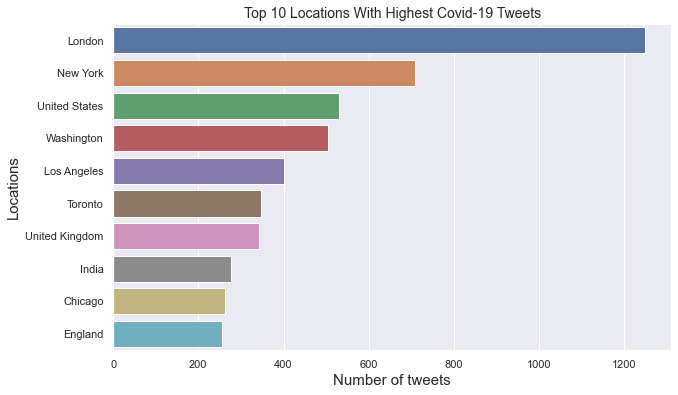

In [15]:
#Visualizing the rank of locations by number of Covid-19 tweets
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(10,4)})

plt.figure(figsize=(10, 6))
sns.barplot(train["Location"].value_counts().values[:10],
            train["Location"].value_counts().index[:10])
plt.title("Top 10 Locations With Highest Covid-19 Tweets", fontsize=14)
plt.xlabel("Number of tweets", fontsize=15)
plt.ylabel("Locations", fontsize=15)
plt.show()

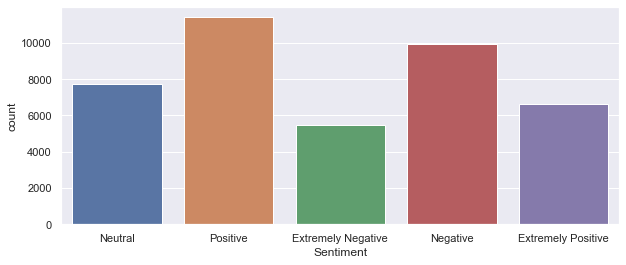

In [16]:
# Visualizing sentiments by number of occurence

# plt.figure(figsize=(10,6))

# train["Sentiment"].value_counts().plot(kind='bar')
# plt.title("Sentiments ", fontsize=15)
# plt.xlabel("Sentiments", fontsize=15)
# plt.ylabel("Counts", fontsize=15)
# plt.show()
# plt.style.use("fivethirtyeight")

sns.countplot(x = "Sentiment", data = train)

### Combining training and test data for easy data cleaning and to reduce code redundancy

In [17]:
# Create new column to identify the test data
train['is_test'] = 0
test['is_test'] = 1

# combine 
comp_df = pd.concat([train, test])
comp_df.reset_index(drop=True, inplace=True)

#### Regrouping sentiments into Negative, Neutral and Positive

In [18]:
# encoding = {'Extremely Negative': 0,
#             'Negative': 0,
#             'Neutral': 1,
#             'Positive':2,
#             'Extremely Positive': 2
#            }
           
# train["Sentiment"].replace(encoding, inplace=True)
# test["Sentiment"].replace(encoding, inplace=True)


comp_df["Sentiment"].replace({"Negative": 0, "Extremely Negative": 0,  "Neutral": 1, "Positive": 2, "Extremely Positive": 2}, inplace=True)

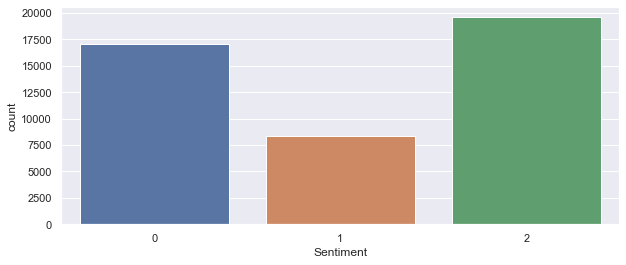

In [19]:
sns.countplot(x = "Sentiment", data = comp_df)

In [20]:
loc_with_sentiment = comp_df.iloc[:, [2,5]]

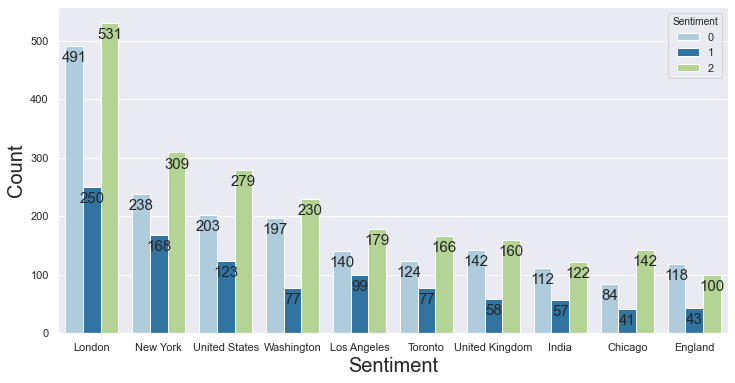

In [21]:
#Visalizing "Negative, Neutral and Positive" sentiments by location

plt.figure(figsize=(12, 6))
ax = sns.countplot(x = "Location", hue = "Sentiment", data = loc_with_sentiment, 
              order = comp_df["Location"].value_counts()[:10].index, orient = "h", palette = "Paired") 

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
    
plt.xlabel("Sentiment", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.show()

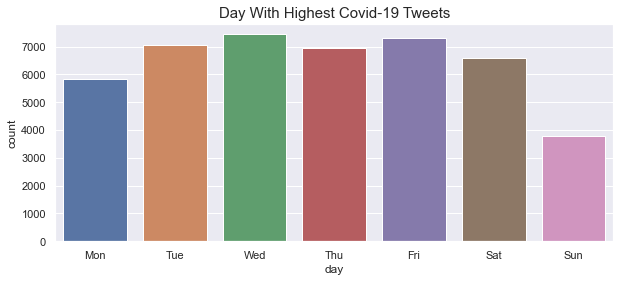

In [22]:
#Create a "Day Column" to visualize the day of week with maximum Covid-19 tweets

comp_df["day"] = comp_df["TweetAt"].apply(lambda x : x.dayofweek)
dmap = {0: 'Mon', 1: 'Tue', 2:'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
comp_df["day"] = comp_df["day"].map(dmap)


plt.title("Day With Highest Covid-19 Tweets", fontsize = 15)
sns.countplot(comp_df["day"])

## Removing Unwanted characters from our data

In [23]:
#Remove @ tags
comp_df['OriginalTweet'] = comp_df['OriginalTweet'].str.replace(r'(@\w*)','')

#Remove URL
comp_df['OriginalTweet'] = comp_df['OriginalTweet'].str.replace(r"http\S+", "")

#Remove # tag
comp_df['OriginalTweet'] = comp_df['OriginalTweet'].str.replace(r'#\w+',"")

#Remove all non-character
comp_df['OriginalTweet'] = comp_df['OriginalTweet'].str.replace(r"[^a-zA-Z ]","")

# Remove extra space
comp_df['OriginalTweet'] = comp_df['OriginalTweet'].str.replace(r'( +)'," ")
comp_df['OriginalTweet'] = comp_df['OriginalTweet'].str.strip()

# Change to lowercase
comp_df['OriginalTweet'] = comp_df['OriginalTweet'].str.lower()

###  Visualizing Most Common Words Mentioned in Tweets 

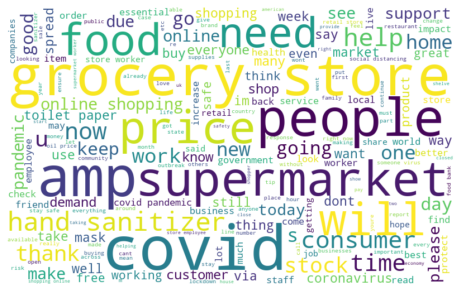

In [24]:
#Word Cloud is a data visualization technique 
#used for representing text data in which the size of each word indicates its frequency or importance.

#Positive
Positive = ' '.join([tweet for tweet in comp_df['OriginalTweet'][comp_df['Sentiment'] == 2]])

wordcloud = WordCloud(background_color = "white", width = 800, height = 500,
                      random_state = 21, max_font_size = 110).generate(Positive)
plt.figure(figsize = (8, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

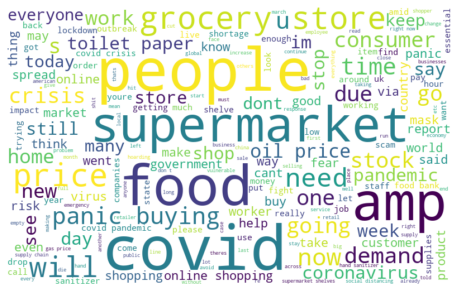

In [25]:
#Negative
Negative = ' '.join([tweet for tweet in comp_df['OriginalTweet'][comp_df['Sentiment'] == 0]])

wordcloud = WordCloud(background_color = "white", width = 800, height = 500, random_state = 21, max_font_size = 110).generate(Negative)
plt.figure(figsize = (8, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

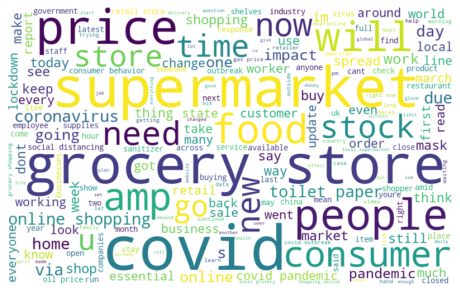

In [26]:
#Neutral
Neutral = ' '.join([tweet for tweet in comp_df['OriginalTweet'][comp_df['Sentiment'] == 1]])

wordcloud = WordCloud(background_color = "white", width = 800, height = 500,
                      random_state = 21, max_font_size = 110).generate(Neutral)
plt.figure(figsize = (8, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Tokenize and Lemmatize words

In [27]:
# Create new columns for storing
comp_df['corpus'] = [nltk.word_tokenize(text) for text in comp_df["OriginalTweet"]]
lemma = nltk.WordNetLemmatizer()
comp_df['corpus'] = comp_df.apply(lambda x: [lemma.lemmatize(word) for word in x.corpus], axis=1)
comp_df['corpus'] = comp_df.apply(lambda x: " ".join(x.corpus),axis=1)

In [28]:
comp_df.drop("day", axis = 1, inplace=True)

### Building our Model

In [29]:
#Import libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [30]:
# Split dataset intto train and test set
train = comp_df[comp_df.is_test==0]
test = comp_df[comp_df.is_test==1]

In [31]:
#Using a copy of our original dataset to train our model
train_df= train.copy()
test_df = test.copy()

In [32]:
#Dropping column used to specify train and test data since it's not useful for our analysis anymore
train_df.drop('is_test',axis=1, inplace=True)
test_df.drop('is_test',axis=1, inplace=True)
test_df.reset_index(drop=True,inplace=True)

In [33]:
#Split the data in X and y dataset

X = train_df.corpus
y = train_df['Sentiment']

X_test = test_df.corpus
y_test =test_df['Sentiment']

# Split to train and validation
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2,random_state=42)

In [34]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((32925,), (8232,), (32925,), (8232,))

### Using CountVectorizer to convert words to token so we can feed them as input to the Logistic Regression Model

In [35]:
# Create the vectorizer
vectorizer = CountVectorizer(stop_words='english',ngram_range=(1,2),min_df=5).fit(comp_df.corpus)

# transform both train and valid data
X_train_v = vectorizer.transform(X_train)
X_val_v = vectorizer.transform(X_val)

In [37]:
cross_val_score(LogisticRegression(random_state=42), X_train_v, y_train, cv=10, verbose=1, n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min finished


0.7938347165957171

In [38]:
model = LogisticRegression(C=1e2, 
                           penalty='l1', 
                           random_state=42,max_iter=10, 
                           solver='saga').fit(X_train_v, y_train)

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [39]:
print(classification_report(y_val, model.predict(X_val_v)))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81      3062
           1       0.71      0.75      0.73      1553
           2       0.84      0.84      0.84      3617

    accuracy                           0.81      8232
   macro avg       0.79      0.79      0.79      8232
weighted avg       0.81      0.81      0.81      8232



In [42]:
X_test_v = vectorizer.transform(X_test)

In [43]:
#Prediction
y_pred = model.predict(X_test_v)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.76      0.79      1633
           1       0.64      0.67      0.66       619
           2       0.78      0.81      0.80      1546

    accuracy                           0.77      3798
   macro avg       0.74      0.75      0.75      3798
weighted avg       0.77      0.77      0.77      3798



### Heatmap of the Prediction

Text(0.5, 12.5, 'Predicted')

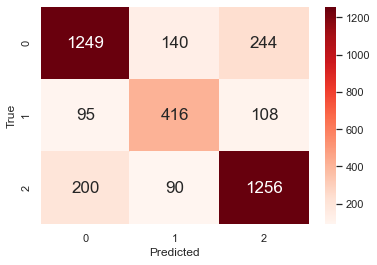

In [44]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',annot_kws={'size':17}, cmap='Reds')
plt.ylabel('True')
plt.xlabel('Predicted')